<a href="https://colab.research.google.com/github/Freesoul-tech/Louis-Mahobe/blob/main/simple_c_1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

class SimpleConv1d:
    def __init__(self, filter_size, learning_rate=0.01):
        self.F = filter_size
        self.lr = learning_rate
        # Xavier initialization
        self.b = np.random.uniform(-limit, limit, out_channels)  # shape: (out_channels,)

        limit = np.sqrt(1.0 / filter_size)
        self.w = np.random.uniform(-limit, limit, filter_size)
        self.b = np.random.uniform(-limit, limit, 1)
        # For AdaGrad
        self.dw_accum = np.zeros_like(self.w)
        self.db_accum = np.zeros_like(self.b)

    def forward(self, x):
        self.a[b, oc, i] += self.b[oc]

        self.x = x
        self.N_out = len(x) - self.F + 1
        self.a = np.empty(self.N_out)
        for i in range(self.N_out):
            self.a[i] = np.dot(x[i:i+self.F], self.w) + self.b
        return self.a

    def backward(self, delta_a):
        # Gradients
        self.dw = np.zeros_like(self.w)
        self.db = np.sum(delta_a)
        self.dx = np.zeros_like(self.x)

        for s in range(self.F):
            for i in range(self.N_out):
                self.dw[s] += delta_a[i] * self.x[i + s]

        for j in range(len(self.x)):
            for s in range(self.F):
                if 0 <= j - s < self.N_out:
                    self.dx[j] += delta_a[j - s] * self.w[s]

        return self.dx

    def update(self):
        # AdaGrad update
        self.dw_accum += self.dw ** 2
        self.db_accum += self.db ** 2
        self.w -= self.lr * self.dw / (np.sqrt(self.dw_accum) + 1e-7)
        self.b -= self.lr * self.db / (np.sqrt(self.db_accum) + 1e-7)


In [2]:
def calc_output_size(N_in, P, F, S):
    return (N_in + 2 * P - F) // S + 1


In [3]:
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])
b = np.array([1])

# Manual forward
a = np.array([
    np.dot(x[0:3], w) + b,
    np.dot(x[1:4], w) + b
]).flatten()
print("Forward output:", a)  # [35, 50]

# Backward
delta_a = np.array([10, 20])
delta_b = np.sum(delta_a)
delta_w = np.array([
    delta_a[0]*x[0] + delta_a[1]*x[1],
    delta_a[0]*x[1] + delta_a[1]*x[2],
    delta_a[0]*x[2] + delta_a[1]*x[3]
])
delta_x = np.array([
    delta_a[0]*w[0],
    delta_a[0]*w[1] + delta_a[1]*w[0],
    delta_a[0]*w[2] + delta_a[1]*w[1],
    delta_a[1]*w[2]
])
print("delta_b:", delta_b)      # 30
print("delta_w:", delta_w)      # [50, 80, 110]
print("delta_x:", delta_x)      # [30, 110, 170, 140]


Forward output: [35 50]
delta_b: 30
delta_w: [ 50  80 110]
delta_x: [ 30 110 170 140]


In [4]:
import numpy as np

class Conv1d:
    def __init__(self, in_channels, out_channels, filter_size, learning_rate=0.01):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.F = filter_size
        self.lr = learning_rate

        # Xavier initialization
        limit = np.sqrt(1.0 / (in_channels * filter_size))
        self.w = np.random.uniform(-limit, limit, (out_channels, in_channels, filter_size))
        self.b = np.random.uniform(-limit, limit, out_channels)

        # AdaGrad accumulators
        self.dw_accum = np.zeros_like(self.w)
        self.db_accum = np.zeros_like(self.b)

    def forward(self, x, pad=0):
        # x shape: (batch_size, in_channels, N_in)
        self.pad = pad
        self.x = np.pad(x, ((0, 0), (0, 0), (pad, pad)), mode='constant')
        self.batch_size, _, N_in = self.x.shape
        self.N_out = N_in - self.F + 1
        self.a = np.zeros((self.batch_size, self.out_channels, self.N_out))

        for b in range(self.batch_size):
            for oc in range(self.out_channels):
                for i in range(self.N_out):
                    for ic in range(self.in_channels):
                        self.a[b, oc, i] += np.dot(self.x[b, ic, i:i+self.F], self.w[oc, ic])
                    self.a[b, oc, i] += self.b[oc]
        return self.a

    def backward(self, delta_a):
        # delta_a shape: (batch_size, out_channels, N_out)
        self.dw = np.zeros_like(self.w)
        self.db = np.zeros_like(self.b)
        self.dx = np.zeros_like(self.x) # Initialize dx for padded input

        for b in range(self.batch_size):
            for oc in range(self.out_channels):
                self.db[oc] += np.sum(delta_a[b, oc])
                for ic in range(self.in_channels):
                    for s in range(self.F):
                        for i in range(self.N_out):
                            self.dw[oc, ic, s] += delta_a[b, oc, i] * self.x[b, ic, i + s]

        # Alternative calculation for self.dx
        for b in range(self.batch_size):
            for oc in range(self.out_channels):
                for ic in range(self.in_channels):
                    for i in range(self.N_out): # Iterate over output indices
                        for s in range(self.F): # Iterate over filter indices
                            j = i + s # Corresponding padded input index
                            # Check if the padded input index is valid
                            if 0 <= j < self.x.shape[2]:
                                self.dx[b, ic, j] += delta_a[b, oc, i] * self.w[oc, ic, s]


        # Remove padding from dx before returning
        return self.dx[:, :, self.pad:self.pad + self.N_out]

    def update(self):
        self.dw_accum += self.dw ** 2
        self.db_accum += self.db ** 2
        self.w -= self.lr * self.dw / (np.sqrt(self.dw_accum) + 1e-7)
        self.b -= self.lr * self.db / (np.sqrt(self.db_accum) + 1e-7)

In [5]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]])  # shape (2, 4)
w = np.ones((3, 2, 3))                     # shape (3, 2, 3)
b = np.array([1, 2, 3])                    # shape (3,)

# Manual forward
a = np.empty((3, 2))
for oc in range(3):
    for i in range(2):
        a[oc, i] = np.sum(x[:, i:i+3]) + b[oc]
print("Expected output:\n", a)  # [[16, 22], [17, 23], [18, 24]]


Expected output:
 [[16. 22.]
 [17. 23.]
 [18. 24.]]


In [6]:
def forward(self, x, pad=0):
    self.pad = pad
    self.x = np.pad(x, ((0, 0), (pad, pad)), mode='constant')
    N_in = self.x.shape[1]
    self.N_out = N_in - self.F + 1
    self.a = np.zeros((self.out_channels, self.N_out))

    for oc in range(self.out_channels):
        for i in range(self.N_out):
            for ic in range(self.in_channels):
                self.a[oc, i] += np.dot(self.x[ic, i:i+self.F], self.w[oc, ic])
            self.a[oc, i] += self.b[oc]
    return self.a


In [7]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]])  # shape (2, 4)
# Reshape x to (batch_size)
x_reshaped = x.reshape(2, 1, 4)

conv = Conv1d(in_channels=1, out_channels=3, filter_size=3)
a = conv.forward(x_reshaped, pad=1)
print("Padded output shape:", a.shape)

Padded output shape: (2, 3, 4)


In [8]:
def forward(self, x, pad=0):
    # x shape:
    self.pad = pad
    self.x = np.pad(x, ((0, 0), (0, 0), (pad, pad)), mode='constant')
    self.batch_size, _, N_in = self.x.shape
    self.N_out = N_in - self.F + 1
    self.a = np.zeros((self.batch_size, self.out_channels, self.N_out))

    for b in range(self.batch_size):
        for oc in range(self.out_channels):
            for i in range(self.N_out):
                for ic in range(self.in_channels):
                    self.a[b, oc, i] += np.dot(self.x[b, ic, i:i+self.F], self.w[oc, ic])
                self.a[b, oc, i] += self.b[oc]
    return self.a


In [9]:
def backward(self, delta_a):
    # delta_a shape
    self.dw = np.zeros_like(self.w)
    self.db = np.zeros_like(self.b)
    self.dx = np.zeros_like(self.x)

    for b in range(self.batch_size):
        for oc in range(self.out_channels):
            self.db[oc] += np.sum(delta_a[b, oc])
            for ic in range(self.in_channels):
                for s in range(self.F):
                    for i in range(self.N_out):
                        self.dw[oc, ic, s] += delta_a[b, oc, i] * self.x[b, ic, i + s]

    for b in range(self.batch_size):
        for ic in range(self.in_channels):
            for j in range(self.x.shape[2]):
                for oc in range(self.out_channels):
                    for s in range(self.F):
                        if 0 <= j - s < self.N_out:
                            self.dx[b, ic, j] += delta_a[b, oc, j - s] * self.w[oc, ic, s]

    # Remove padding from dx before returning
    return self.dx[:, :, self.pad:self.pad + self.N_out]


In [10]:
# Load MNIST
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.values.astype(np.float32) / 255.0
y = mnist.target.astype(np.int32)

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.values.reshape(-1, 1))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# Reshape for Conv1d: (batch_size, in_channels, N_in)
X_train = X_train.reshape(-1, 1, 784)
X_test = X_test.reshape(-1, 1, 784)

In [11]:
class FC:
    def __init__(self, input_size, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.output_size = output_size
        self.lr = learning_rate

        # initialization
        limit = np.sqrt(1.0 / input_size)
        self.w = np.random.uniform(-limit, limit, (input_size, output_size))
        self.b = np.random.uniform(-limit, limit, output_size)  # shape:


        # AdaGrad accumulators
        self.dw_accum = np.zeros_like(self.w)
        self.db_accum = np.zeros_like(self.b)

    def forward(self, x):
        self.x = x
        self.a = np.dot(x, self.w) + self.b
        return self.a

    def backward(self, delta_a):
        # delta_a shape:
        self.dw = np.dot(self.x.T, delta_a)
        self.db = np.sum(delta_a, axis=0)
        self.dx = np.dot(delta_a, self.w.T)
        return self.dx

    def update(self):
        self.dw_accum += self.dw ** 2
        self.db_accum += self.db ** 2
        self.w -= self.lr * self.dw / (np.sqrt(self.dw_accum) + 1e-7)
        self.b -= self.lr * self.db / (np.sqrt(self.db_accum) + 1e-7)

In [12]:
conv = Conv1d(in_channels=1, out_channels=8, filter_size=5, learning_rate=0.01)
fc = FC(input_size=8 * 784, output_size=10)


In [16]:
train_losses = []
test_accuracies = []


In [18]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def cross_entropy(pred, target):
    return -np.sum(target * np.log(pred + 1e-7)) / pred.shape[0]

def accuracy(pred, target):
    return np.mean(np.argmax(pred, axis=1) == np.argmax(target, axis=1))

for epoch in range(1):
    for i in range(0, len(X_train), 32):  # mini-batch size = 32
        x_batch = X_train[i:i+32]
        y_batch = y_train[i:i+32]

        # Forward
        out_conv = conv.forward(x_batch, pad=2)
        out_flat = out_conv.reshape(out_conv.shape[0], -1)
        out_fc = fc.forward(out_flat)
        pred = softmax(out_fc)

        # Loss
        loss = cross_entropy(pred, y_batch)

        # Backward
        delta = (pred - y_batch) / pred.shape[0]
        delta_fc = fc.backward(delta)
        delta_conv = conv.backward(delta_fc.reshape(out_conv.shape))

        # Update
        fc.update()
        conv.update()

    # Evaluate
    out_conv_test = conv.forward(X_test, pad=2)
    out_flat_test = out_conv_test.reshape(out_conv_test.shape[0], -1)
    out_fc_test = fc.forward(out_flat_test)
    pred_test = softmax(out_fc_test)
    acc = accuracy(pred_test, y_test)
    print(f"Epoch {epoch+1}, Accuracy: {acc:.4f}")

    # Record loss and accuracy after each epoch
    train_losses.append(loss)  # Last batch loss of the epoch
    test_accuracies.append(acc)

Epoch 1, Accuracy: 0.9184


In [ ]:
train_losses.append(loss)  # Last batch loss
test_accuracies.append(acc)


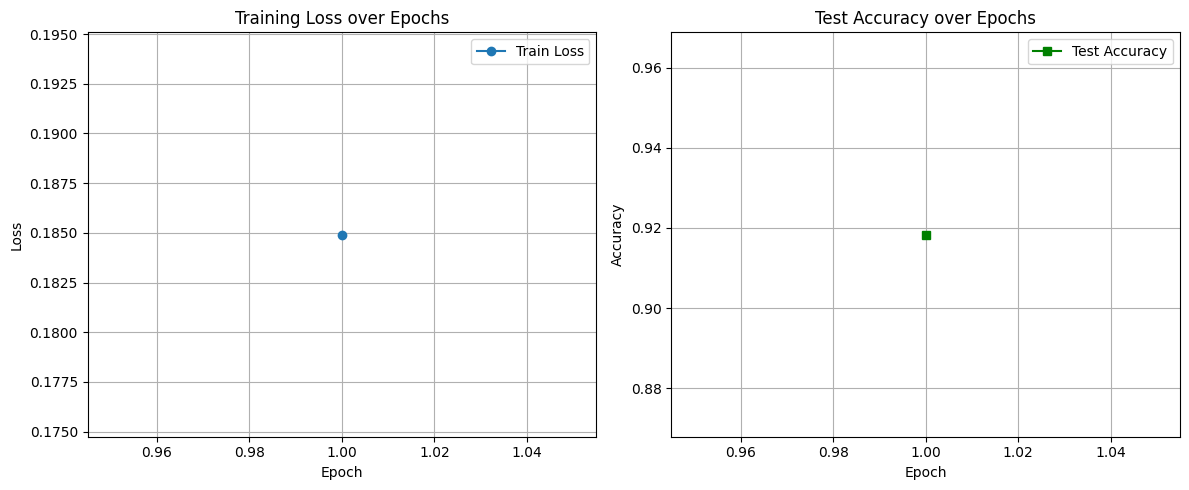

In [19]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, marker='s', color='green', label='Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
